# Import Library

In [1]:
# Import External Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob

import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.metrics import MeanSquaredError

from scipy import stats
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

D:\Downloads\anaconda\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Read CSV Data

In [2]:
# Read Data Train
df_train = pd.read_csv(r'D:\Downloads\FDR Landing - Excel\train_set.csv')
df_val = pd.read_csv(r'D:\Downloads\FDR Landing - Excel\val_set.csv')
df_test = pd.read_csv(r'D:\Downloads\FDR Landing - Excel\test_set.csv')

In [3]:
features_col = ['gs_mps','ax_body_mps2', 'hdot_1_mps', 'hralt_m']
targets_col = ['pla_1_rad', 'pla_2_rad', 'pla_3_rad', 'pla_4_rad']

##### Plot each features used, to see each feature value range

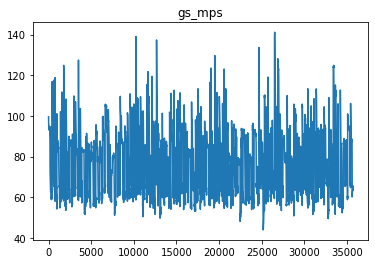

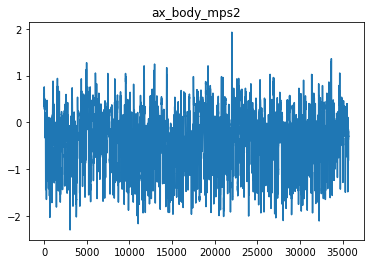

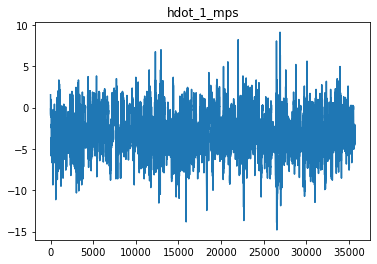

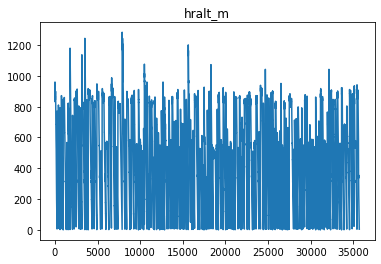

In [4]:
for col_name in features_col:
    plt.plot(df_train[col_name])
    plt.title(col_name)
    plt.show()

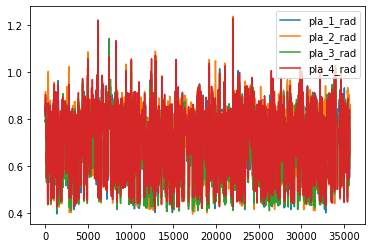

In [6]:
for col_name in targets_col:
    plt.plot(df_train[col_name], label = col_name)
    plt.legend(loc='best')

# Create Feature & Target Data

##### Features and targets data type will be converted first as 'float32' and then by using MinMaxScaler, we normalize only the features to have value between 0 and 1

In [11]:
X_train = df_train[features_col].values.astype('float32')
X_val = df_val[features_col].values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
transformer = scaler.fit(X_train)
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)


y_train = df_train[targets_col].values.astype('float32')
y_val = df_val[targets_col].values.astype('float32')

## Hyperparamater Tuning using Keras Tuner

* First, we need to define the based model function that can be seen in 'call_existing_ANN' function
* The based model consist of hyperparameter variable that will be tuned.
* We will use basic dense model, with loss function = MSE and metrics = MAE

## Define model function

In [13]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import TensorBoard

hp = kt.HyperParameters()

def call_existing_ANN(units1, units_hidden, activation,initializer, activation_hidden, optimizer, dropout,do_rate, lr, num_hidden, x_train, y_train):
    model = Sequential()                            
    model.add(Dense(units=units1,
                    input_dim=(x_train.shape[1]),
                    kernel_initializer=initializer))
    
    # Add Hidden layers
    for i in range(num_hidden):
        model.add(Dense(units=units_hidden,
                       activation=activation_hidden))

    # Add dropout layers
    if dropout:
        model.add(Dropout(rate=do_rate))
        
    model.add(Dense(y_train.shape[1],
                    activation=activation))
    
    # Compiling Model
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=["mean_absolute_error"])
    
    return model

* In the 'build_model' function below, we define hyperparameter space of the variable we mention earlier
* Then, we call the 'call_existing_ANN' function and filll the parameter with the space variable

In [14]:
def build_model(hp):
    units1 = hp.Int("units1", min_value=8, max_value=32, step=4)
    units_hidden = hp.Int("units_hidden", min_value=8, max_value=32, step=4)
    initializer = hp.Choice("initalizer", ['zeros','glorot_normal','he_normal'])
    num_hidden = hp.Choice('num_hidden', [0,1,2])
    activation_hidden = hp.Choice("activation_hidden", ['elu','LeakyReLU'])
    activation = hp.Choice("activation", ['elu','LeakyReLU'])
    optimizer = hp.Choice("optimizer", ['sgd', 'rmsprop', 'adam'])
    dropout = hp.Boolean("dropout")
    dropout_rate = hp.Float("rate", min_value=0.1, max_value=0.5, step=0.1)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    
    # Learning rate for optimizer 
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate = lr)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate = lr)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate = lr)
    
    # Dropout rate
    if dropout == True:
        do_rate = dropout_rate
    
    # call existing model-building code with the hyperparameter values.
    model = call_existing_ANN(units1=units1, units_hidden=units_hidden,
                               activation=activation, dropout=dropout,do_rate=dropout_rate,
                              activation_hidden = activation_hidden,
                              initializer=initializer,
                               lr=lr, optimizer=optimizer,
                               num_hidden = num_hidden,
                               x_train=X_train, y_train=y_train)
    return model

In [15]:
# Build the model consisting the hyperparameter space

build_model(kt.HyperParameters())

In [16]:
project_name = input('Project name:')

Project name:throttle_17oct_v1


* Now, we define the method of KerasTuner library that we want to use. In this case we choose Bayesian Optimization. 
* We can specify the function we create as the hypermodel, objective that we want (loss or val loss), and how many trials the iteration process will be, also each set of hyperparameter executions in this case 1 set will be execute 1 time.\
* In this process, we use 50 trials to get best hyperparameter set, eventhough number of combinations of the hyperparameter that can be tried is very big. But to shorten computation time and find the local minimum value, we think 50 trials is enough 

In [17]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="loss",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name=project_name)

* We use tuner.search by specifying features and targets, how many epochs it will be trained, and validation variable data we use
* We choose 5 for the epochs value, because we don't want to use 1 epochs because it will be very variative loss in the first epochs, and we choose 5 because to shorthen computation time while seeing more converge value than 1 epochs do.

In [18]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=1)

Trial 50 Complete [00h 00m 49s]
loss: 0.008416960015892982

Best loss So Far: 0.0068348245695233345
Total elapsed time: 00h 46m 09s
INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.results_summary()

Results summary
Results in my_dir\throttle_17oct_v1
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 32
units_hidden: 8
initalizer: he_normal
num_hidden: 2
activation_hidden: LeakyReLU
activation: LeakyReLU
optimizer: adam
dropout: False
rate: 0.5
lr: 0.0030087982533023297
Score: 0.0068348245695233345
Trial summary
Hyperparameters:
units1: 8
units_hidden: 8
initalizer: he_normal
num_hidden: 2
activation_hidden: elu
activation: elu
optimizer: adam
dropout: False
rate: 0.5
lr: 0.008790626742161222
Score: 0.007031231187283993
Trial summary
Hyperparameters:
units1: 32
units_hidden: 8
initalizer: he_normal
num_hidden: 2
activation_hidden: elu
activation: elu
optimizer: adam
dropout: False
rate: 0.1
lr: 0.002721761848951717
Score: 0.007297651842236519
Trial summary
Hyperparameters:
units1: 8
units_hidden: 20
initalizer: he_normal
num_hidden: 2
activation_hidden: LeakyReLU
activation: elu
optimizer: adam
dropout: False
rate: 0.5
lr: 0.1
Score: 0.0076607586815953255
Trial summary


##### Next, we will train our dataset using best hyperparameter from Bayesian Optimization result

* We use early stopping when loss variable value is stucked, so we can iterate until 200 epochs

In [21]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hps)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size = 128, callbacks=[stop_early])

Epoch 1/200
279/279 [==============================] - 3s 9ms/step - loss: 0.0242 - mean_absolute_error: 0.0988 - val_loss: 0.0106 - val_mean_absolute_error: 0.0778
Epoch 2/200
279/279 [==============================] - 2s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0676 - val_loss: 0.0104 - val_mean_absolute_error: 0.0780
Epoch 3/200
279/279 [==============================] - 2s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0676 - val_loss: 0.0101 - val_mean_absolute_error: 0.0762
Epoch 4/200
279/279 [==============================] - 2s 6ms/step - loss: 0.0079 - mean_absolute_error: 0.0680 - val_loss: 0.0103 - val_mean_absolute_error: 0.0778
Epoch 5/200
279/279 [==============================] - 2s 7ms/step - loss: 0.0078 - mean_absolute_error: 0.0672 - val_loss: 0.0099 - val_mean_absolute_error: 0.0754
Epoch 6/200
279/279 [==============================] - 2s 9ms/step - loss: 0.0077 - mean_absolute_error: 0.0669 - val_loss: 0.0100 - val_mean_absolute_error: 0.0763
Epoch 7/20

279/279 [==============================] - 2s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0531 - val_loss: 0.0078 - val_mean_absolute_error: 0.0635
Epoch 100/200
279/279 [==============================] - 2s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0537 - val_loss: 0.0076 - val_mean_absolute_error: 0.0624
Epoch 101/200
279/279 [==============================] - 2s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0533 - val_loss: 0.0075 - val_mean_absolute_error: 0.0623
Epoch 102/200
279/279 [==============================] - 2s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0534 - val_loss: 0.0074 - val_mean_absolute_error: 0.0624
Epoch 103/200
279/279 [==============================] - 2s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0530 - val_loss: 0.0076 - val_mean_absolute_error: 0.0626
Epoch 104/200
279/279 [==============================] - 2s 7ms/step - loss: 0.0053 - mean_absolute_error: 0.0531 - val_loss: 0.0073 - val_mean_absolute_error: 0.0617
Epoch 105/20

279/279 [==============================] - 4s 13ms/step - loss: 0.0052 - mean_absolute_error: 0.0528 - val_loss: 0.0078 - val_mean_absolute_error: 0.0627
Epoch 198/200
279/279 [==============================] - 3s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0526 - val_loss: 0.0077 - val_mean_absolute_error: 0.0627
Epoch 199/200
279/279 [==============================] - 3s 10ms/step - loss: 0.0051 - mean_absolute_error: 0.0521 - val_loss: 0.0079 - val_mean_absolute_error: 0.0637
Epoch 200/200
279/279 [==============================] - 3s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0524 - val_loss: 0.0079 - val_mean_absolute_error: 0.0636


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                160       
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
Total params: 532
Trainable params: 532
Non-trainable params: 0
_________________________________________________________________


##### From the best hyperparameter model that have been trained, we will see the prediction result from this model on the validation set and compare it to targeted value

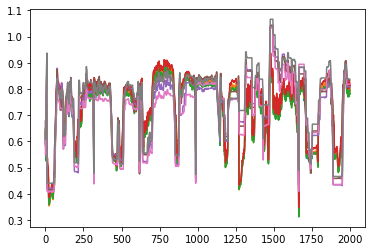

In [16]:
plt.plot(model.predict(X_val)[:2000])
plt.plot(y_val[:2000])

##### It can be seen that 4 graphs from predicted value and 4 graph from the real data show the same pattern and range of value. 

## Plot MSE & MAE vs epochs

<AxesSubplot:title={'center':'Loss'}>

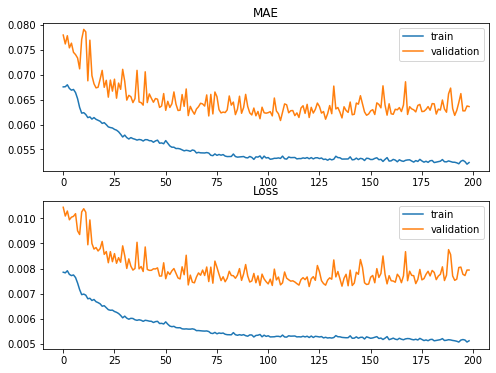

In [24]:
fig,axs = plt.subplots(2,figsize=(8,6))

loss_train = history.history['loss']
loss_val = history.history['val_loss']

metrics_train = history.history['mean_absolute_error']
metrics_val = history.history['val_mean_absolute_error']

pd.Series(metrics_train[1:]).rename('train').plot(legend=True,title='MAE',ax=axs[0])
pd.Series(metrics_val[1:]).rename('validation').plot(legend=True,ax=axs[0])

pd.Series(loss_train[1:]).rename('train').plot(legend=True,title='Loss',ax=axs[1])
pd.Series(loss_val[1:]).rename('validation').plot(legend=True,ax=axs[1])

* From graph above, we can see the training process converge to certain value. Where the validation set MSE and MAE graph is bigger or above the train set.

* It shows that our model doesn't encounter overfitting. 

* Hence, we can save the model as *.h5 file

# Save Model

In [25]:
model.save("throttle_17oct_v1.h5")

## Load saved h5 model

In [7]:
h5_file_name_load = 'throttle_17oct_v1.h5'

In [8]:
# Load Model from h5 file
model = keras.models.load_model(h5_file_name_load)

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                160       
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
Total params: 532
Trainable params: 532
Non-trainable params: 0
_________________________________________________________________


##### The last step is to use our model to predict each landing phase file and see wether the trend of power lever angle deflection of predicted value is similar enough to the real value

# Test On Test Set

File Name: Landing_100.csv


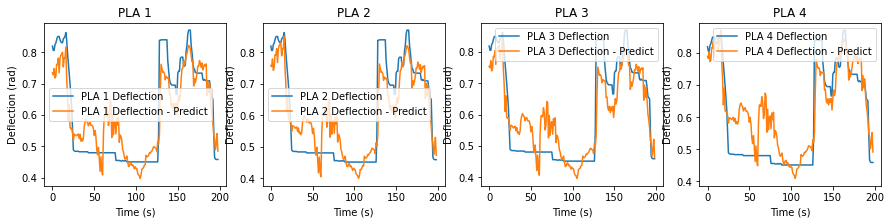

File Name: Landing_105.csv


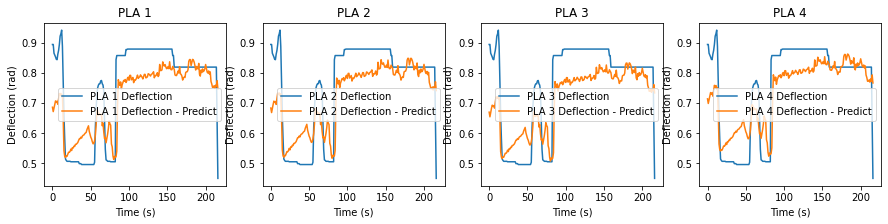

File Name: Landing_110.csv


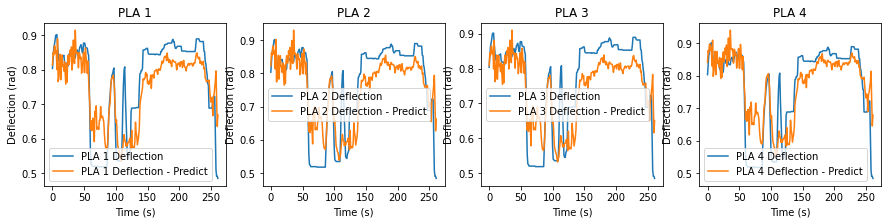

File Name: Landing_126.csv


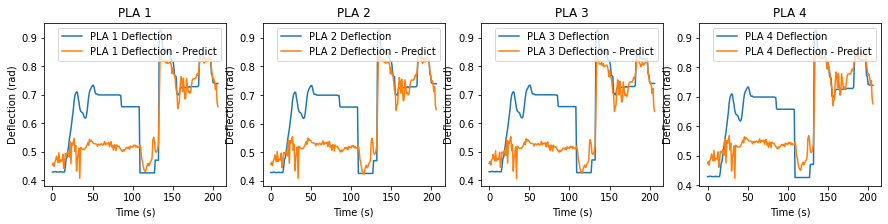

File Name: Landing_13.csv


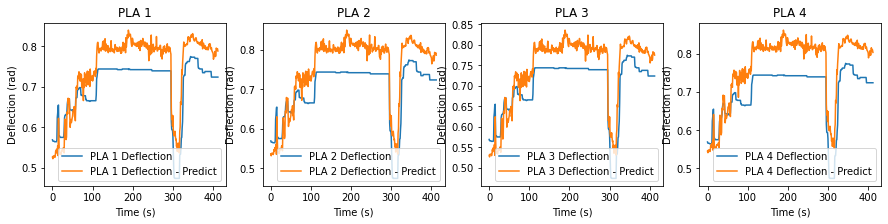

File Name: Landing_135.csv


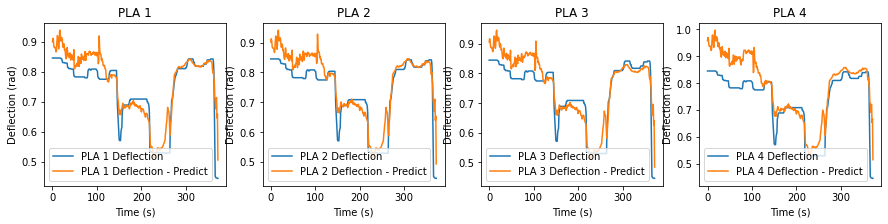

File Name: Landing_145.csv


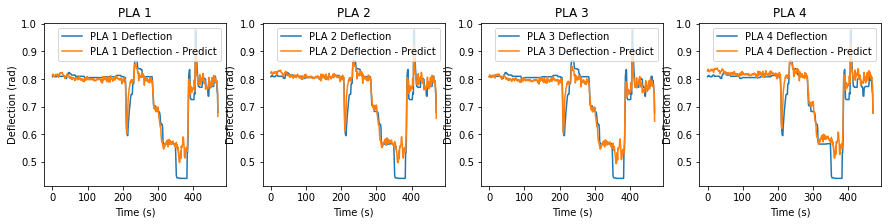

File Name: Landing_147.csv


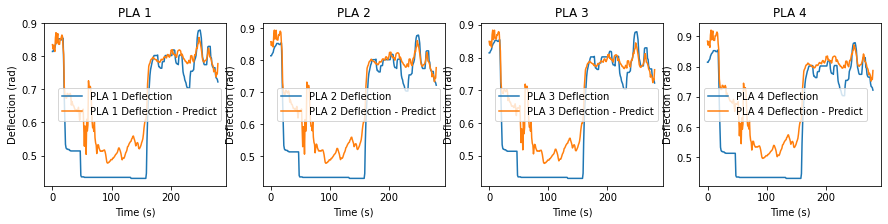

File Name: Landing_152.csv


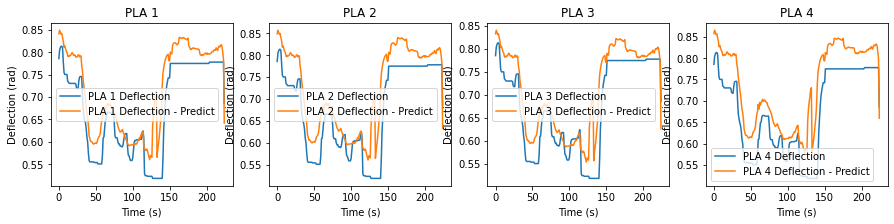

File Name: Landing_156.csv


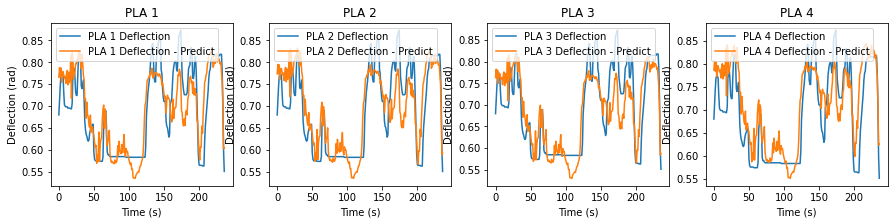

File Name: Landing_162.csv


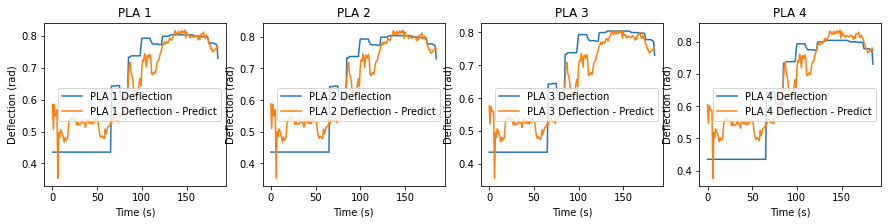

File Name: Landing_167.csv


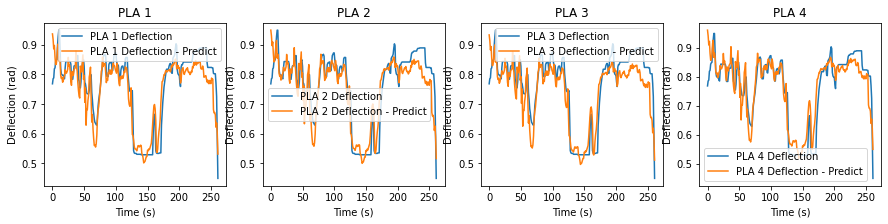

File Name: Landing_174.csv


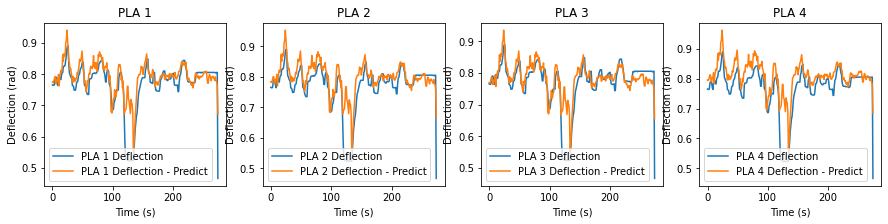

File Name: Landing_194.csv


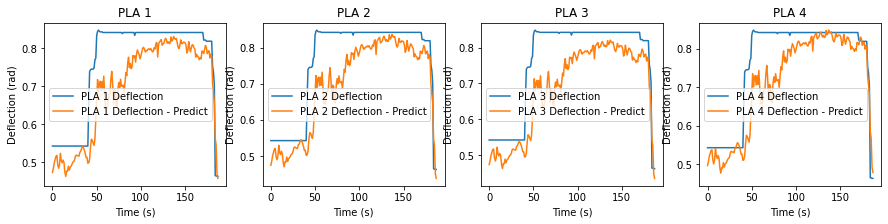

File Name: Landing_26.csv


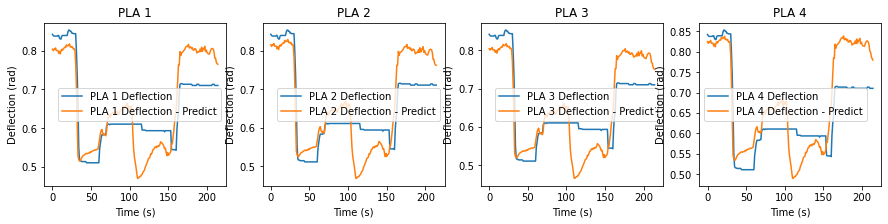

File Name: Landing_32.csv


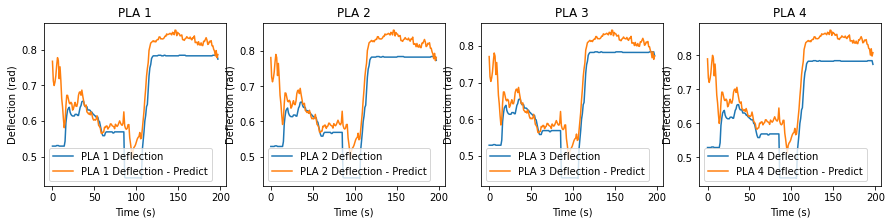

File Name: Landing_77.csv


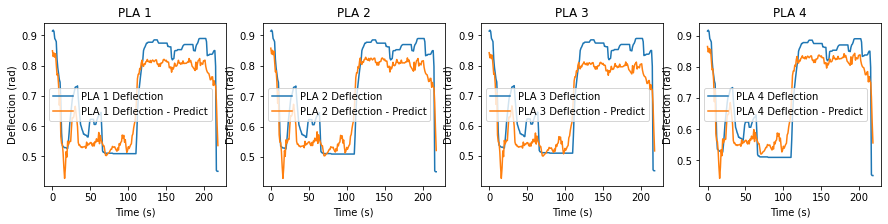

File Name: Landing_84.csv


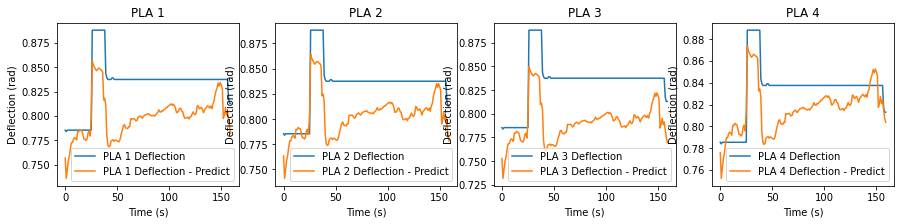

File Name: Landing_90.csv


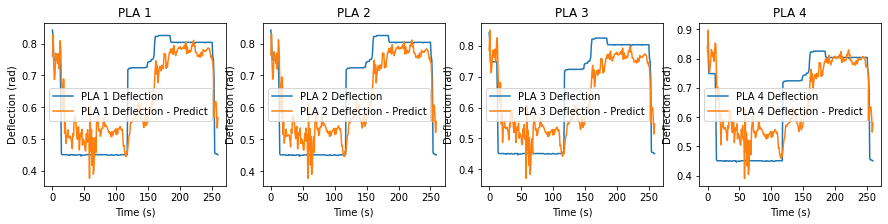

File Name: Landing_98.csv


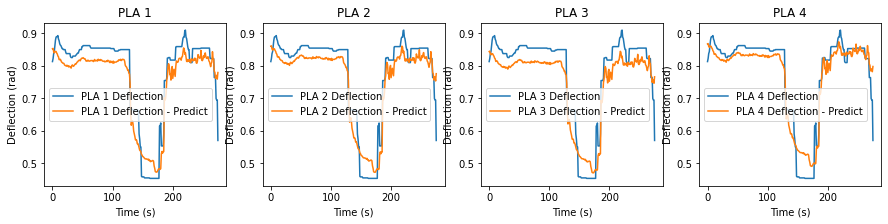

In [12]:
# Import Library
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from numpy import isnan, arange, rad2deg


# loop over the list of csv files

csv_files =  [i for i in glob.glob('D:\Downloads\FDR Landing - Excel\Test Set\*.csv')]

for f in csv_files:

    df_test = pd.read_csv(f)
    
    # Create  X_test and y_test variable using df_to_array function
    X_test = df_test[features_col].values.astype('float32')
    X_test = transformer.transform(X_test)
    y_test = df_test[targets_col].values.astype('float32')

    # Predict X_test using model that have been created
    PLA = model.predict(X_test)
    
    # Initate 4 empty list for each PLA and extract corresponding value from PLA variable
    pla_1 = []
    pla_2 = []
    pla_3 = []
    pla_4 = []
     
    for i in range(len(PLA)):
        pla_1.append(PLA[i][0])
        pla_2.append(PLA[i][1])
        pla_3.append(PLA[i][2])
        pla_4.append(PLA[i][3])

    # Print each file name
    print('File Name:', f.split("\\")[-1])
    
    # Create subplot
    fig, ax = plt.subplots(nrows = 1, ncols =4, figsize=(15,3))

    ax[0].plot(df_test[targets_col].iloc[:,0], label='PLA 1 Deflection')
    ax[0].plot(pla_1, label='PLA 1 Deflection - Predict')
    ax[0].set_title("PLA 1")
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Deflection (rad)')
    ax[0].legend(loc='best')
    
    ax[1].plot(df_test[targets_col].iloc[:,0], label='PLA 2 Deflection')
    ax[1].plot(pla_2, label='PLA 2 Deflection - Predict')
    ax[1].set_title("PLA 2")
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Deflection (rad)')
    ax[1].legend(loc='best')
    
    ax[2].plot(df_test[targets_col].iloc[:,0], label='PLA 3 Deflection')
    ax[2].plot(pla_3, label='PLA 3 Deflection - Predict')
    ax[2].set_title("PLA 3")
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Deflection (rad)')
    ax[2].legend(loc='best')
    
    ax[3].plot(df_test[targets_col].iloc[:,0], label='PLA 4 Deflection')
    ax[3].plot(pla_4, label='PLA 4 Deflection - Predict')
    ax[3].set_title("PLA 4")
    ax[3].set_xlabel('Time (s)')
    ax[3].set_ylabel('Deflection (rad)')
    ax[3].legend(loc='best')

    plt.show()


##### It can be seen that our model can follow the actual value trend, for all of the PLA variable. The problem here is the PLA deflection is fluctuated rather than have step graph like how pilot constantly give some certain angle for throttle. 

##### But overall, we can say that our model is succes to modeling power lever angle deflection in landing phase.